In [1]:
"""
King's College London
6CCS3EEP

Implementation of C-Elegan Brain/Neuronal Dynamics using Spiking Neural Networks

Author: Aamir Faaiz <mohamed.faaiz@kcl.ac.uk>
        Xorsheed Zanjani <xorsheed.zanjani@kcl.ac.uk>
Date: December 2020

Instructions: Run this code block first
Note: Kernal will have to be resarted to clear all variables stored in memory
"""
import numpy as np
import matplotlib.pyplot as plt
import time
# from neuron_params import *
from weights import getMatrix,accessWeights
from scipy.stats import norm

plt.style.use('dark_background')

### Dynamics Model & Neuron Circuit for Contour Tracking

Schematic of the neural circuit for contour tracking. N1 is a temperature sensitive input neuron. N1 − N3 is a positive comparator, and N7−N8−N9 is a gradient detector. Similarly, N1−N2 is a complementary comparator, and N4 − N5 − N6 is a gradient detector. N6 and N9 control the deterministic turns, while N10 controls the random exploration.

<img src="img/block-diagram.png" alt="Block Diagram" width="400" height="400"> <img src="img/neuron-circuit.png" alt="Neuron Circuit" width="400" height="400">

In [2]:
#Functions
def simulateLIF(dt,I,C,gL,EL,VT,W,ker,Nk,Ibias):
    '''Approximate LIF Neuron dynamics by Euler's method.

    Parameters
    ----------
    dx :number
       Total time being simulated (ms) and Euler time-step (ms)
       
    C,gL,EL,VT:number
        neuronal parameters
     
    I:1D NumPy array
        Input current (pA)
    
    W:1D NumPy array
        Synaptic Weight Strengths  - Connectivity Matrix
    
    ker:1D NumPy Array
        Current Kernal
    
    Ibias: NumPy Array
        Current Bias
    
    Returns
    -------
    V,Isyn :  NumPy array (mV), NumPy array (pA)
        Approximation for membrane potential computed by Euler's method.
    '''
    
    V=EL*np.ones((np.shape(I)[0],2*np.shape(I)[1])) #initialising V
    stim=np.zeros((np.shape(I)[0],2*np.shape(I)[1])) #initialising synaptic stimulus

    Isyn = np.vstack(Ibias[:np.shape(I1)[0]])*np.ones((np.shape(I1)[0],2*np.shape(I1)[1])) #initialising synaptic current to bias
    for n in range(0,np.shape(I)[1]-1):
        V[:,n+1] = V[:,n] + (dt/C)*(I[:,n]+Isyn[:,n] -gL*(V[:,n]-EL))
        check=np.where(V[:,n+1]>VT)[0]
        if np.size(check)>0:
            V[check,n+1]=EL
            V[check,n]=1.8*VT #Artificial Spike
            stim[check,n+1:n+1+Nk] += ker
            Isyn[:,n+1:] += 1000*np.matmul(W,stim[:,n+1:])
    return V,Isyn

def currentGen(scale,num_pulses):
    ''''Current Generation with a varying pulse width

    Parameters
    ----------
    scale: number
        Factor to increase pulse width by
    num_pulses: number
        Number of pulses to generate
    Returns
    -------
    Iinp: 1D NumPy Array Current Matrix
    '''
    Iinp=np.zeros(1)
    ton = scale*(np.arange(num_pulses)+1)
    for n in range(0,len(ton)):
        Iinp = np.hstack([Iinp, 2800*np.ones(ton[n])]) 
        Iinp = np.hstack([Iinp, np.zeros(400)])
    return Iinp
    
def currentKernal(dT,tau1,tau2,kerlen):
    ''''Kernal Generation Based on Equation 3

    Parameters
    ----------
    dT: number
        Time-step (ms)
    tau1, tau2: number
        Time Constants
    kerlen: number
        Time Span of Kernal (ms)
    Returns
    -------
    ker,Nk: Current Kernal, Number of Kernals
    '''
    # Obtaining kernel
    Nk = np.int_(kerlen/dT)
    xker = np.linspace(0, kerlen,Nk , endpoint=True)
    ker =  np.array(np.exp(-xker/tau1)-np.exp(-xker/tau2))
    return ker,Nk


def plotter(x,y1,title,yaxlabel,y1label=None,y2=None,y2label=None,usedark=False):
    '''Graph Plotting

    Parameters
    ----------
    x:1D NumPy array
       NumPy array to be used as the x-axis data
       
   y1,y2:1D NumPy array
        NumPy array to be used as the y-axis data
     
       
    yaxlabel:String
        Y axis label
    
    y1label,y2label:String
        Legend Labels
    
     title:String
         Graph title
         
    '''
    plt.style.use('dark_background') if usedark else plt.style.use('default')
    plt.figure(figsize=(10,5)) #Customisable size
    plt.rcParams.update({'font.size': 15})
    plt.grid(True)
    plt.plot(x,y1,'g-', label = y1label)
    if(y2 is not None):plt.plot(x,y2,'r-', label = y2label),plt.legend()
    plt.title(title)
    plt.xlabel("Time/ms")
    plt.ylabel(yaxlabel)
    plt.show()
    
def currentInputGen(T,Ts,alpha,beta):
    """
    T: Temperature Input
    Ts: Set Temperature Point
    alpha,beta: constants
    
    returns: Current Input for Neuron 1(pA)
    """
    return (alpha+beta)*(T-Ts)

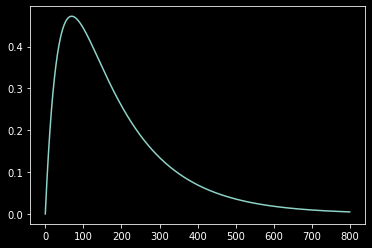

In [3]:
#Global paramaters  - constant for all problems
#Neuron Parameters
C = 300 
gL = 30
EL = -70
VT = 20 
dt = 0.1 #timestep
# Obtaining kernel
kerlen = 80
tau1 = 15
tau2 = 3.75
ker,Nk = currentKernal(dt,tau1,tau2,kerlen)
plt.plot(ker)

### Experimenting with Temperature Comparators

We need two comparators:
1) Negative Comparator: $T<T_s$ Detection  
2) Positive Comparator: $T>T_s$ Detection

A complementary comparator (i.e., a network that
produces a proportional spike response for deviations of
local temperature below the set-point) can be realized by
making w negative and $I_{bias}$ positive.

### Positive Comparator

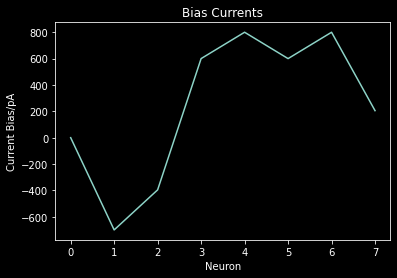

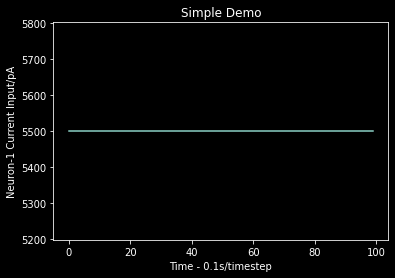

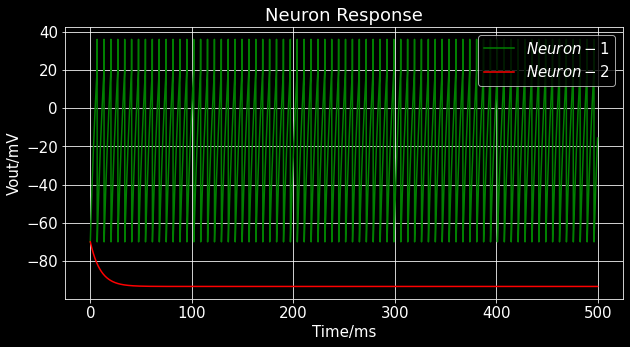

In [4]:
Ibias = [0,-700,-396,600,800,600,800,205]
plt.plot(Ibias)
plt.xlabel("Neuron")
plt.ylabel("Current Bias/pA")
plt.title("Bias Currents")
plt.show()
#T =  np.random.randint(100, size=5000) #Random Temperatures
alpha = 600 #pA
beta = 500 #pA/K
T = 25*np.ones(5000) #Constant Temperature of 23C
Iinp1 = currentInputGen(T,20,alpha,beta) #Set Threshold Temperature to 20C
plt.plot(Iinp1[:100])
plt.xlabel('Time - 0.1s/timestep')
plt.ylabel("Neuron-1 Current Input/pA")
plt.title("Simple Demo")
plt.show()

T = 5000 #Total time of simulation
iter=np.int_(T/dt) #Number of timesteps
Numneurons = 2
I1 = np.vstack((Iinp1,np.zeros((Numneurons-1,np.shape(Iinp1)[0]))))
t = dt*(np.arange(len(I1[1])))

#Connectivity Matrix
W1=[[0,300],
   [0,0]]

Vmem1,Isyn1 = simulateLIF(dt,I1,C,gL,EL,VT,W1,ker,Nk,Ibias) #Simulate
# #Plotting Synaptic Curents
# plotter(t,Isyn1[0,0:np.shape(I1)[1]],
#         "Synaptic Current",
#         "Isyn/pA",
#         '$Synapse_{12}$',
#         Isyn1[1,0:np.shape(I1)[1]],
#         '$Synapse_{21}$',True)
#Plotting Neuron Response
plotter(t,Vmem1[0,0:np.shape(I1)[1]],
        "Neuron Response",
        "Vout/mV",
        '$Neuron-1$',
        Vmem1[1,0:np.shape(I1)[1]],
        '$Neuron-2$',True)

### Negative Comparator

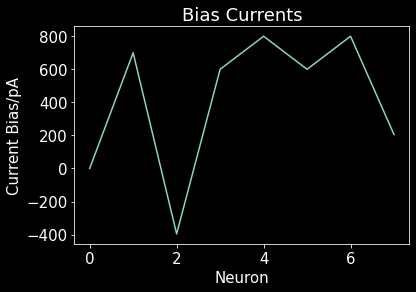

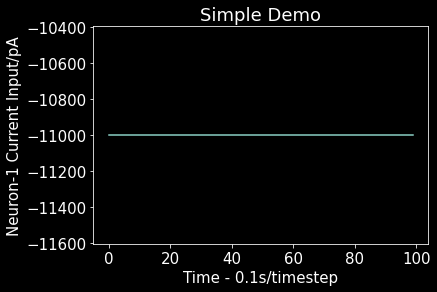

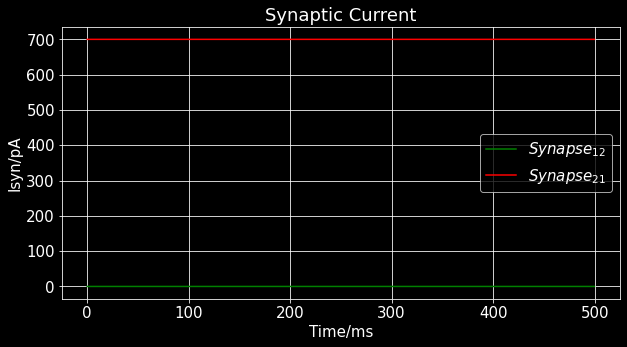

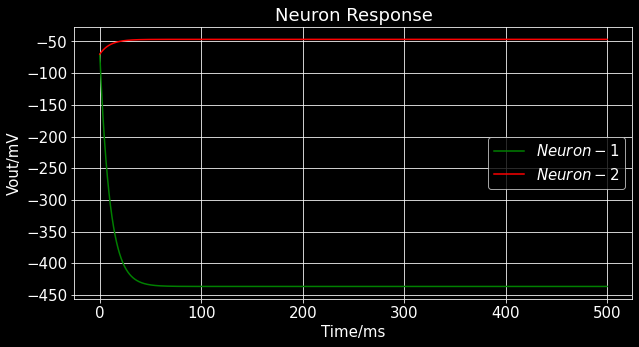

In [8]:
Ibias2 = [0,700,-396,600,800,600,800,205] #Changing Ibias for Neuron2 to positive
plt.plot(Ibias2)
plt.xlabel("Neuron")
plt.ylabel("Current Bias/pA")
plt.title("Bias Currents")
plt.show()
#T =  np.random.randint(100, size=5000) #Random Temperatures
alpha = 600 #pA
beta = 500 #pA/K
T = 15*np.ones(5000) #Constant Temperature of 15C
Iinp2 = currentInputGen(T,25,alpha,beta) #Threshold Temperature of 25C
plt.plot(Iinp2[:100])
plt.xlabel('Time - 0.1s/timestep')
plt.ylabel("Neuron-1 Current Input/pA")
plt.title("Simple Demo")
plt.show()

T = 5000 #Total time of simulation
iter=np.int_(T/dt) #Number of timesteps
Numneurons = 2
I2 = np.vstack((Iinp2,np.zeros((Numneurons-1,np.shape(Iinp2)[0]))))
t = dt*(np.arange(len(I2[1])))

#Connectivity Matrix
W2=[[0,-300],
   [0,0]] #Setting weight to negative

Vmem2,Isyn2 = simulateLIF(dt,I2,C,gL,EL,VT,W2,ker,Nk,Ibias2) #Simulate
#Plotting Synaptic Curents
plotter(t,Isyn2[0,0:np.shape(I2)[1]],
        "Synaptic Current",
        "Isyn/pA",
        '$Synapse_{12}$',
        Isyn2[1,0:np.shape(I2)[1]],
        '$Synapse_{21}$',True)
#Plotting Neuron Response
plotter(t,Vmem2[0,0:np.shape(I2)[1]],
        "Neuron Response",
        "Vout/mV",
        '$Neuron-1$',
        Vmem2[1,0:np.shape(I2)[1]],
        '$Neuron-2$',True)